# Building a SMS spam detector

**Goal** is to predict whether an email to spam or not spam

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
# load the dataset
path = '/Users/liamhettinger/Documents/Portfolio_work/Data/sms.tsv.txt'
sms = pd.read_csv(path, sep='\t', header=None, names=['label', 'message'])

### Data Exploration

In [3]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# spam example
print(sms[sms.label=='spam'].message.iloc[100])

To review and KEEP the fantastic Nokia N-Gage game deck with Club Nokia, go 2 www.cnupdates.com/newsletter. unsubscribe from alerts reply with the word OUT


In [5]:
# acceptable example
print(sms[sms.label=='ham'].message.iloc[100])

Hmm...my uncle just informed me that he's paying the school directly. So pls buy food.


In [6]:
sms.label.value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

## Training a Naive Bayes model

In [7]:
# feature matrix/target vector
X = sms.message
y = sms.label

In [8]:
# train/test split
X_train,X_test,y_train,y_test = train_test_split(X,y)

In [9]:
pipe = Pipeline(steps=[
    ('vect', TfidfVectorizer()), #Countvectorizer with inverse document-frequency.
    ('clf', MultinomialNB()) #Initializing a Naive Bayes Model.
])

In [10]:
#Setting up parameters for grid search.
params_dic =  {'vect__max_features' : [1000,2000,5000,10000],
               'vect__stop_words' : ['english', None],
               'vect__min_df' : [5,10,20,50],
               'vect__ngram_range' : [(1,1), (1,2),(1,3)]}

In [11]:
#Searching for the optimal using cross validation
grid = GridSearchCV(pipe,params_dic,scoring='accuracy',cv=5, n_jobs=-1, verbose=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'vect__max_features': [1000, 2000, 5000, 10000],
                         'vect__min_df': [5, 10, 20, 50],
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vect__stop_words': ['english', None]},
             scoring='accuracy', verbose=True)

In [12]:
#The training sets accuracy score. The best accuracy score acheived during cross validation.
grid.best_score_

0.9803799100363865

In [13]:
#The TfidfVectorizer parameters that acheive the best results on the holdout sample.
grid.best_params_

{'vect__max_features': 2000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english'}

In [14]:
#Creating a Naive Bayes model using the optimal parameters.
best_clf = grid.best_estimator_

In [15]:
# transform testing data (using fitted vocabulary) into a document-term matrix
y_test_pred = grid.predict(X_test)

In [16]:
# accuracy
nb_accuracy = accuracy_score(y_test, y_test_pred)
nb_accuracy

0.9734386216798278

In [17]:
# confusion matrix
nb_confusion = confusion_matrix(y_test, y_test_pred)
nb_confusion

array([[1188,    0],
       [  37,  168]])

In [18]:
#Type 2 Errors (spam incorrectly classified as ham)
X_test[(y_test=='spam') & (y_test_pred=='ham')]

2663    Hello darling how are you today? I would love ...
1640    FreeMsg:Feelin kinda lnly hope u like 2 keep m...
869     Hello. We need some posh birds and chaps to us...
1172    Got what it takes 2 take part in the WRC Rally...
4256    Block Breaker now comes in deluxe format with ...
1350    FREE2DAY sexy St George's Day pic of Jordan!Tx...
2295     You have 1 new message. Please call 08718738034.
5110      You have 1 new message. Please call 08715205273
788     Ever thought about living a good life with a p...
2965    Do you ever notice that when you're driving, a...
660     88800 and 89034 are premium phone services cal...
3548    Rock yr chik. Get 100's of filthy films &XXX p...
2109    FREE2DAY sexy St George's Day pic of Jordan!Tx...
3574    You won't believe it but it's true. It's Incre...
4676    Hi babe its Chloe, how r u? I was smashed on s...
3132    LookAtMe!: Thanks for your purchase of a video...
68      Did you hear about the new "Divorce Barbie"? I...
2699          

In [19]:
#Type 1 Errors (ham incorrectly classified as spam) 
X_test[(y_test=='ham') & (y_test_pred=='spam')]

Series([], Name: message, dtype: object)

## How does Naive Bayes choose between spam and ham

In [20]:
# Naive Bayes counts the number of times each word appears in each class
# Rows represent classes (ham and spam), columns represent words
grid.best_estimator_.named_steps.clf.feature_count_

array([[ 0.        ,  0.        ,  0.        , ...,  0.83692946,
         1.04624957, 16.79443918],
       [ 1.89077538,  4.82492562,  2.01257485, ...,  1.95737297,
         0.61620878,  0.        ]])

In [21]:
grid.best_estimator_.named_steps.clf.classes_

array(['ham', 'spam'], dtype='<U4')

In [22]:
# create a DataFrame of words with their separate Hamilton and Madison counts
words = pd.DataFrame({'Words' : grid.best_estimator_.named_steps.vect.get_feature_names_out(), 'ham' : grid.best_estimator_.named_steps.clf.feature_count_[0,:], 'spam' : grid.best_estimator_.named_steps.clf.feature_count_[1,:]}).set_index('Words')
words.sample(5)

,ham,spam
Words,,
holiday,3.006145,5.042264
ans,0.825174,1.645147
won guaranteed,0.000000,1.598389
kallis,3.048075,0.000000
reply,9.018012,14.821721


In [23]:
# add 1 to the columns counts to avoid dividing by 0
words.ham = words.ham+1
words.spam = words.spam+1

In [24]:
# convert the ham and spam counts into frequencies
words.ham = words.ham/words.ham.sum()
words.spam = words.spam/words.spam.sum()
# calculate the ratio of ham-to-spam and spam-to-ham for each word
words['ham_ratio'] = words.ham/words.spam
words['spam_ratio'] = words.spam/words.ham

In [25]:
# top 20 spam words
words.sort_values(by='spam_ratio', ascending=False).head(5)

,ham,spam,ham_ratio,spam_ratio
Words,,,,
claim,0.000109,0.004499,0.024180,41.357204
prize,0.000109,0.003817,0.028503,35.083647
www,0.000132,0.004434,0.029875,33.473096
150p,0.000109,0.003378,0.032203,31.053009
uk,0.000142,0.003699,0.038298,26.110952


In [26]:
# top 20 ham words
words.sort_values(by='ham_ratio', ascending=False).head(5)

,ham,spam,ham_ratio,spam_ratio
Words,,,,
gt,0.006018,0.000276,21.781325,0.045911
lt,0.005840,0.000276,21.137182,0.047310
ok,0.009296,0.000461,20.171281,0.049575
lt gt,0.005333,0.000276,19.300408,0.051812
da,0.004623,0.000276,16.733685,0.059760


## Example with Logistic Regression

In [27]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()

In [28]:
#The count vectorizer parameters that acheive the best results on the holdout sample.
grid.best_params_

{'vect__max_features': 2000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english'}

In [29]:
# initializing vector
vect = TfidfVectorizer(max_features = 2000, min_df = 5, ngram_range = (1, 1), stop_words = None)
# fitting X_train to count vectorizer
vect = vect.fit(X_train)
# Transforming X_train and X_test
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_test)

In [30]:
#fitting model
log_clf.fit(X_train_dtm,y_train)

LogisticRegression()

In [31]:
#predicting y_test
y_test_pred = log_clf.predict(X_test_dtm)

In [32]:
#Logistic Regression model accuracy
accuracy_score(y_test, y_test_pred)

0.9669777458722182

In [33]:
#Naive Bayes Accuracy
nb_accuracy

0.9734386216798278

In [34]:
#Logistic Regression model's confusion matrix
confusion_matrix(y_test, y_test_pred)

array([[1186,    2],
       [  44,  161]])

In [35]:
#Naive Bayes model's confusion matrix
nb_confusion

array([[1188,    0],
       [  37,  168]])

In [36]:
#incorrect predictions. Predicted it was real but it was spam
X_test[(y_test=='spam') & (y_test_pred == 'ham')]

2663    Hello darling how are you today? I would love ...
1640    FreeMsg:Feelin kinda lnly hope u like 2 keep m...
869     Hello. We need some posh birds and chaps to us...
5466    http//tms. widelive.com/index. wml?id=820554ad...
1172    Got what it takes 2 take part in the WRC Rally...
4256    Block Breaker now comes in deluxe format with ...
1350    FREE2DAY sexy St George's Day pic of Jordan!Tx...
788     Ever thought about living a good life with a p...
3010    Update_Now - 12Mths Half Price Orange line ren...
2965    Do you ever notice that when you're driving, a...
660     88800 and 89034 are premium phone services cal...
3548    Rock yr chik. Get 100's of filthy films &XXX p...
2109    FREE2DAY sexy St George's Day pic of Jordan!Tx...
3574    You won't believe it but it's true. It's Incre...
4676    Hi babe its Chloe, how r u? I was smashed on s...
529     You will recieve your tone within the next 24h...
3132    LookAtMe!: Thanks for your purchase of a video...
1449    As a r

In [37]:
# coefficients
pd.DataFrame(data=log_clf.coef_.T, index = vect.get_feature_names_out(), columns = ['coefficients'])

,coefficients
00,0.737000
000,0.811662
03,0.370303
04,0.603912
06,0.465602
...,...
yours,0.808454
yourself,-0.108365
yr,0.531386
yrs,0.122397


<Axes: >

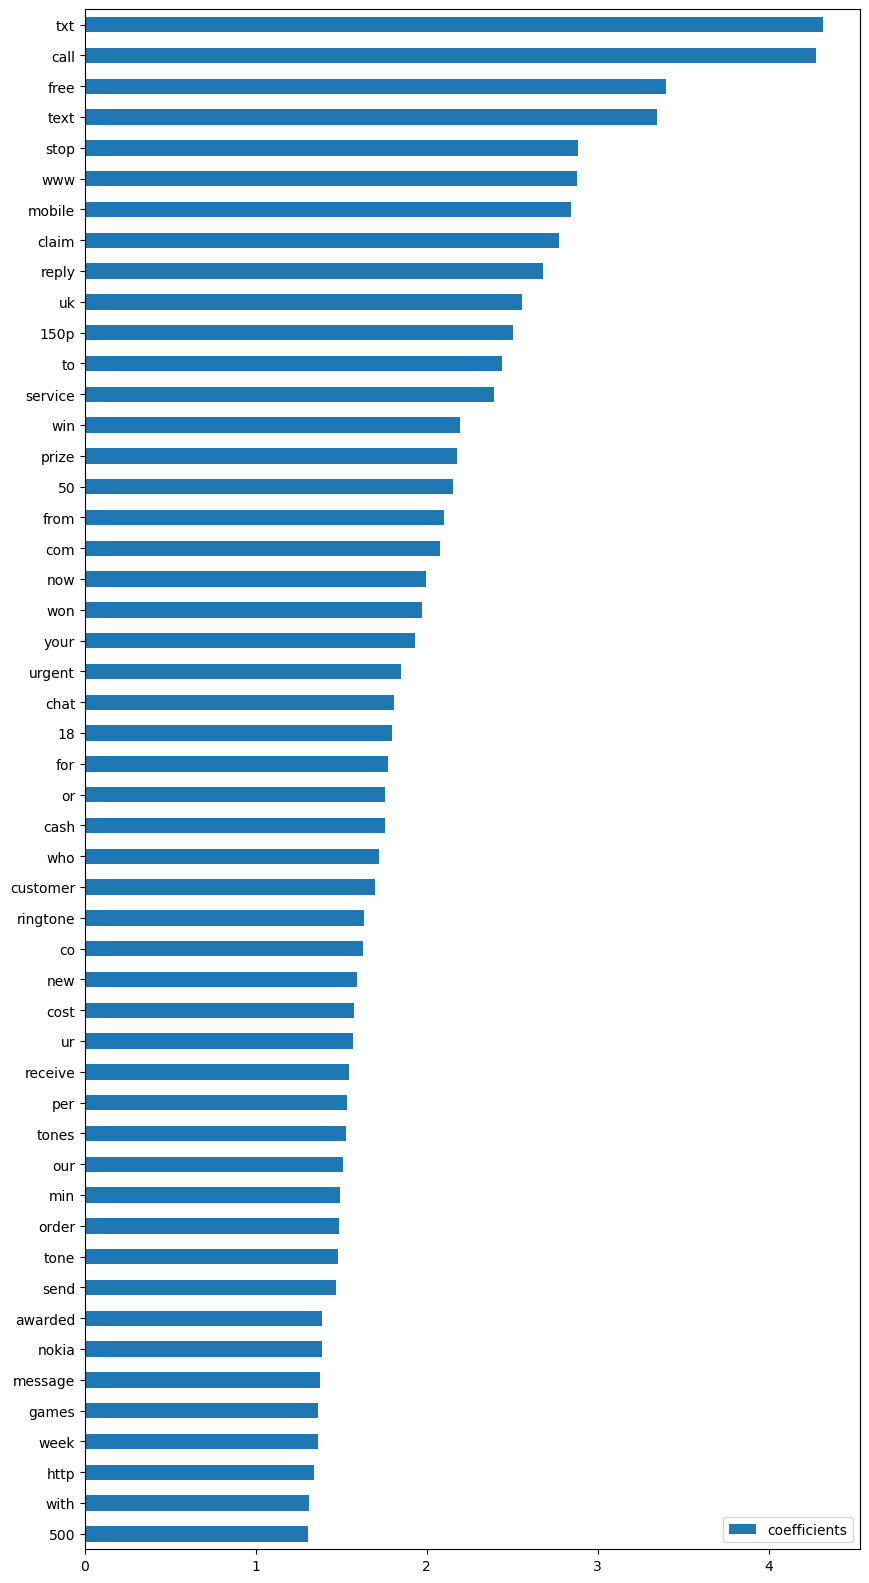

In [38]:
# coefficients for spam
coeff = pd.DataFrame(data=log_clf.coef_.T, index = vect.get_feature_names_out(), columns = ['coefficients'])
coeff.sort_values(by = 'coefficients').tail(50).plot.barh(figsize=(10,20))

In [39]:
# top 20 coefficients or words that are good indicators of spam
coeff.sort_values(by = 'coefficients', ascending = False).head(20)

,coefficients
txt,4.317368
call,4.274769
free,3.399435
text,3.347347
stop,2.884465
www,2.878096
mobile,2.841421
claim,2.769943
reply,2.677711
uk,2.557485
